## Yacine Mahdid May 30 2020
The goal of this notebook is to generate the visualization from the results gathered in the first phase. This step is separated from result generation as we don't need lots of computing power for visualization.

### Steps:
- [ ] Double check that all the results are in the right format and can be unpickled
- [ ] Generate Violin plot for the bootstrap confidence interval
- [ ] Generate Feature importance plot


In [20]:
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from ml_tools.classification import load_pickle

# Double checking that all the results are in the right format and can be unpickled
input_dir = '/home/yacine/Documents/BIAPT/eeg_pain_result/BOTH/'
output_dir = '/home/yacine/Documents/BIAPT/eeg_pain_result/BOTH/'

# Basic information
features_filename = input_dir + 'features_all.csv'

# Clf performance
acc_filename = input_dir + 'accuracies_result.pickle'
f1_filename = input_dir + 'f1s_result.pickle'

# Clf validation
best_params_filename = input_dir + 'best_params.pickle'
bootstrap_filename = input_dir + 'bootstrap.pickle'
permutation_filename = input_dir + 'permutation_test.pickle'

# Final Clf explanability information
clf_filename = input_dir + 'trained_gs.pickle'
features_weight_filename = input_dir + 'features.pickle'


In [21]:
# Original dataframe used to generate the result
df = pd.read_csv(features_filename)

In [22]:
accuracies = load_pickle(acc_filename)
f1s = load_pickle(f1_filename)

{'SVC_kernel=linear_C=10': 65}
(0.610640506456953, 0.6864339650979646)


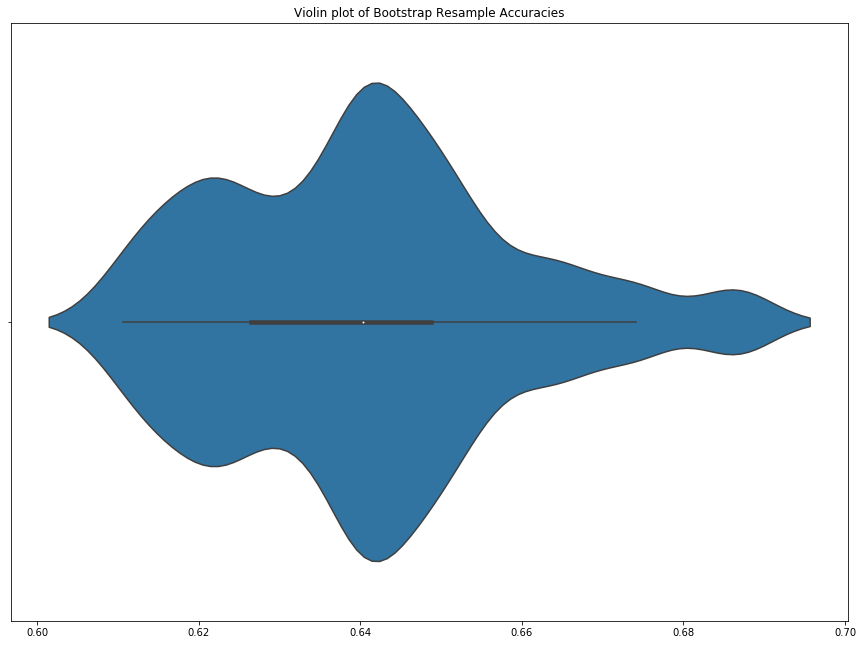

In [23]:
def find_best_model(best_params):
    models_occurence = {}
    for param in best_params:
        clf = param['clf']
        if isinstance(clf, LogisticRegression):
            key = "LOG" + "_penality=" + str(clf.penalty) + "_C=" + str(clf.C)
        elif isinstance(clf, LinearSVC):
            key = "SVC" + "_kernel=linear_C=" + str(clf.C)
        elif isinstance(clf, DecisionTreeClassifier):
            key = "DEC" + "_criterion" + str(clf.criterion)

        if key not in models_occurence:
            models_occurence[key] = 1
        else:
            models_occurence[key] = models_occurence[key] + 1

    return models_occurence

# Will need to double check how I'm doing this I'm getting difficult to parse result
best_params = load_pickle(best_params_filename)
print(find_best_model(best_params))

# This is a dictionary with two key: distribution and interval
bootstrap = load_pickle(bootstrap_filename)
#bootstrap['distribution']
print(bootstrap['interval'])

fig_name = output_dir + 'bootstrap_resampling.png'
fig = plt.gcf()
ax = sns.violinplot(bootstrap['distribution'])
ax.set_title("Violin plot of Bootstrap Resample Accuracies")
fig.set_size_inches((15, 11), forward=False)
fig.savefig(fig_name, dpi=500)

# This is the n run of the permutation testing
permutation = load_pickle(permutation_filename)

In [24]:
# Trained classifier (Where is this one coming from?)
clf = load_pickle(clf_filename)

/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid res

Size Name:  156
Size Weight:  157


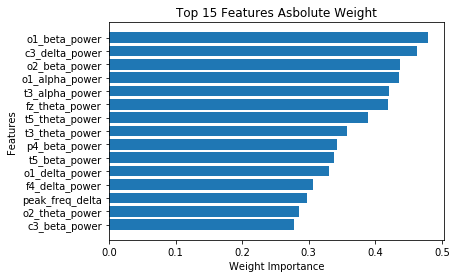

In [25]:
def f_importances(coef, names, fig_name, top=-1):
    '''Helper function to plot the feature importance'''
    imp = abs(coef)
    imp,names = zip(*sorted(zip(imp,names)))
    
    # Show all features
    if top == -1:
        top = len(names)
        
    limit = len(names) - top
    
    plt.barh(range(top), imp[limit:], align='center')
    plt.yticks(range(top), names[limit:])
    plt.title(f"Top {top} Features Asbolute Weight")
    plt.xlabel("Weight Importance")
    plt.ylabel("Features")
        
    fig = plt.gcf()
    plt.show()
    fig.set_size_inches((15, 11), forward=False)
    fig.savefig(fig_name, dpi=500)
    
# This might be better as a dataframe
features_weight = load_pickle(features_weight_filename)
weight_importance_filename = output_dir + 'f_importance.png'
print("Size Name: ", len(features_weight['name']))
print("Size Weight: ", len(features_weight['weight']))

f_importances(features_weight['weight'], features_weight['name'],  weight_importance_filename, 15)

In [97]:
features_weight['name']

['fp1_delta_power',
 'fp2_delta_power',
 'fz_delta_power',
 'f3_delta_power',
 'f4_delta_power',
 'f7_delta_power',
 'f8_delta_power',
 'cz_delta_power',
 'c3_delta_power',
 'c4_delta_power',
 't3_delta_power',
 't4_delta_power',
 't5_delta_power',
 't6_delta_power',
 'pz_delta_power',
 'p3_delta_power',
 'p4_delta_power',
 'o1_delta_power',
 'o2_delta_power',
 'peak_freq_delta',
 'fp1_delta_wpli',
 'fp2_delta_wpli',
 'fz_delta_wpli',
 'f3_delta_wpli',
 'f4_delta_wpli',
 'f7_delta_wpli',
 'f8_delta_wpli',
 'cz_delta_wpli',
 'c3_delta_wpli',
 'c4_delta_wpli',
 't3_delta_wpli',
 't4_delta_wpli',
 't5_delta_wpli',
 't6_delta_wpli',
 'pz_delta_wpli',
 'p3_delta_wpli',
 'p4_delta_wpli',
 'o1_delta_wpli',
 'o2_delta_wpli',
 'fp1_theta_power',
 'fp2_theta_power',
 'fz_theta_power',
 'f3_theta_power',
 'f4_theta_power',
 'f7_theta_power',
 'f8_theta_power',
 'cz_theta_power',
 'c3_theta_power',
 'c4_theta_power',
 't3_theta_power',
 't4_theta_power',
 't5_theta_power',
 't6_theta_power',
 'pz_

158
